### Install or import dependencies

In [11]:
try:
    import torchdiffeq
except ModuleNotFoundError:
    !pip install --quiet torchdiffeq
    import torchdiffeq
import numpy as np
import torch
import torch.nn as nn
import torchdiffeq as diff
from torchdiffeq import odeint
import csv
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, ExponentialLR
import time
import random
import os
import logging

print(torchdiffeq.__version__)

0.2.3


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read dataset and split into training, validation, and testing

In [ ]:
# filename = "/content/drive/MyDrive/EC523 Final Project/Data/simulated_dataset-42_G=0.5_sumSteps=200.csv"

# # Read data
# with open(filename, 'r') as csvfile:
#     trajs = torch.tensor([[float(value) for value in row] for row in csv.reader(csvfile)])

In [4]:
# # define function to round down to nearest 200
# def rounddown(x, number):
#   '''Rounds down to the nearest multiple of number specified'''
#   return int(np.floor(x / number)) * number

# # split data into training, validation, and testing
# # trajectories are randomly initiated, so there is no need to further randomize

# rows = trajs.shape[0]
# train_split = 0.7
# val_split = 0.15

# train_stop = rounddown(rows*train_split, 200)
# val_stop = train_stop + rounddown(rows*val_split, 200)

# train_data = trajs[:train_stop,:]
# val_data = trajs[train_stop:val_stop,:]
# test_data = trajs[val_stop:,:]

train_file = "/content/drive/MyDrive/EC523 Final Project/Data/simulated_dataset-42_G=0.5_sumSteps=200_TRAIN.csv"
val_file = "/content/drive/MyDrive/EC523 Final Project/Data/simulated_dataset-42_G=0.5_sumSteps=200_VAL.csv"
test_file = "/content/drive/MyDrive/EC523 Final Project/Data/simulated_dataset-42_G=0.5_sumSteps=200_TEST.csv"

# np.savetxt(train_file, train_data, delimiter=",")
# np.savetxt(val_file, val_data, delimiter=",")
# np.savetxt(test_file, test_data, delimiter=",")

### Define custom dataset for associating initial conditions with trajectories

In [5]:
# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, filename, device, num_gpus, num_steps = 200):
        with open(filename, 'r') as csvfile:

          # read the provided file
          self.trajs = torch.tensor([[float(value) for value in row] for row in csv.reader(csvfile)])

        self.num_steps = num_steps

    def __getitem__(self, idx):

        # file divided into chunks of num_steps rows
        start_index = self.num_steps*idx
        end_index = start_index + self.num_steps

        # columns 4 to end contain positions and velocities
        # take as input to the model the initial condition of the trajectory
        input = self.trajs[start_index,4:]

        # as "label" take the whole trajectory
        label = self.trajs[start_index:end_index,4:]

        return input, label

    def __len__(self): # return length of dataset
        if len(self.trajs) % self.num_steps != 0:
            raise ValueError("Total number of rows in the dataset is not divisible by num_steps")

        length = len(self.trajs)//self.num_steps
        return length

### Define neural network model itself

In [6]:
class NeuralODE(nn.Module):
    def __init__(self, input_dim, output_dim, reservoir_size=128):
        super(NeuralODE, self).__init__()

        # Define the forward pass of the network
        self.f = nn.Sequential(
            nn.Linear(input_dim, reservoir_size),
            nn.ReLU(),
            nn.Linear(reservoir_size, reservoir_size),
            nn.ReLU(),
            nn.Linear(reservoir_size, output_dim)
        )

    def forward(self, t, state):

        # output represents the derivative of the state
        state_dot = self.f(state)

        return state_dot


### Define evaluation function

In [7]:
def evaluate_model(model, dataloader, device, max_batches = None):

    # put in eval mode in case any dropout used, etc.
    model.eval()
    criterion = nn.MSELoss()

    with torch.no_grad():

        num_samples = 0
        total_error = 0
        for idx, (inputs, targets) in enumerate(dataloader):

            # move input and targets to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass
            # Define the time points
            timesteps = torch.linspace(0, 2, 200)
            timesteps = timesteps.to(device)

            # Simulate the system using the neural ODE
            outputs = odeint(model, inputs, timesteps, method='dopri5')
            outputs = outputs.permute(1,0,-1)

            loss = criterion(outputs,targets)

            # increment total error and number of samples
            total_error += loss.item()*inputs.size(0)
            num_samples += inputs.size(0)

            if max_batches is not None and idx + 1 == max_batches:
                break

    return total_error / num_samples

In [8]:
import matplotlib.pyplot as plt


def evaluate_graphs(model, dataloader, device, max_batches = None):

    # put in eval mode in case any dropout used, etc.
    model.eval()
    criterion = nn.MSELoss()

    with torch.no_grad():

        num_samples = 0
        total_error = 0
        for idx, (inputs, targets) in enumerate(dataloader):

            # move input and targets to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass
            # Define the time points
            timesteps = torch.linspace(0, 2, 200)
            timesteps = timesteps.to(device)

            # Simulate the system using the neural ODE
            outputs = odeint(model, inputs, timesteps, method='dopri5')
            outputs = outputs.permute(1,0,-1)

            #print('outputs', outputs)
            #print('targets', targets)

            # co-plot both of these

            loss = criterion(outputs,targets)

            # increment total error and number of samples
            total_error += loss.item()*inputs.size(0)
            num_samples += inputs.size(0)

            if max_batches is not None and idx + 1 == max_batches:
                break

    return outputs, targets

In [14]:
def graph_traj(model_traj, sim_traj):
# Choose which state array to use to make sure they're all the same
# state_array = states_all
# state_array = states_all_reshaped
  num_steps = 200
  dim = 2
  sim_state_array = sim_traj.cpu()
  model_state_array = model_traj.cpu()

# Set a seed for reproducibility
  rng_plot = np.random.default_rng(seed=781)

# Randomly select rows from 'state_array'
  random_indices = rng_plot.choice(len(sim_state_array), size=4, replace=False)  # size = 4 so we can do a 2x2 grid
  sim_selected_rows = sim_state_array[random_indices,0,:] # use the same random indicies from above
  model_selected_rows = model_state_array[random_indices,0,:]

# Add a column for random indices
  sim_selected_rows_with_indices = np.column_stack((sim_selected_rows, random_indices))
  model_selected_rows_with_indices = np.column_stack((model_selected_rows, random_indices))
  fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex='all', sharey = 'all')
  axs = axs.flatten()

# Perform simulations and plot trajectories for both functions
  for i, row in enumerate(sim_selected_rows_with_indices):
    idx = int(row[-1]) # index from full list of initial conditions

    sim_states = sim_state_array[idx,:,1:] # remove time column (not really necessary)
    model_states = model_state_array[idx,:,1:] # remove time column (not really necessary)
    sim_positions_over_time_flat = sim_state_array[idx,:,-12:-6]
    sim_velocities_over_time_flat = sim_state_array[idx,:,-6:]
    model_positions_over_time_flat = model_state_array[idx,:,-12:-6]
    model_velocities_over_time_flat = model_state_array[idx,:,-6:]

    # Reshape for plotting
    sim_positions_over_time = sim_positions_over_time_flat.reshape((num_steps, 3, dim))
    sim_velocities_over_time = sim_velocities_over_time_flat.reshape((num_steps, 3, dim))
    sim_initial_velocities = sim_velocities_over_time[0]
    model_positions_over_time = model_positions_over_time_flat.reshape((num_steps, 3, dim))
    model_velocities_over_time = model_velocities_over_time_flat.reshape((num_steps, 3, dim))
    model_initial_velocities = model_velocities_over_time[0]

    # Plot
    sim_colors = ['#E69F00', '#56B4E9', '#9e0010']
    ax_lim = 2
    for particle_number in range(3):
      x = sim_positions_over_time[:, particle_number, 0]
      y = sim_positions_over_time[:, particle_number, 1]
      color = sim_colors[particle_number]
      axs[i].plot(
            x, y,
            color=color, label=f'Particle {particle_number + 1}'
      )
      axs[i].scatter(x[0], y[0], s=20, color=color, marker='o', label=f'_Initial Position Particle {particle_number + 1}')
      axs[i].set_xlim([-ax_lim, ax_lim])
      axs[i].set_ylim([-ax_lim, ax_lim])

      # Plot initial velocity vectors
      vx, vy = sim_initial_velocities[particle_number]
      #axs[i].quiver(x[0], y[0], vx, vy, angles='xy', scale_units='xy', scale=2, color='grey', width=0.005)

    model_colors = ['#e6cf00', '#56e9dd', '#ed7e07']
    for particle_number in range(3):
      x = model_positions_over_time[:, particle_number, 0]
      y = model_positions_over_time[:, particle_number, 1]
      color = model_colors[particle_number]
      axs[i].plot(
            x, y,
            color=color, label=f'Particle {particle_number + 1}'
      )
      axs[i].scatter(x[0], y[0], s=20, color=color, marker='o', label=f'_Initial Position Particle {particle_number + 1}')
      axs[i].set_xlim([-ax_lim, ax_lim])
      axs[i].set_ylim([-ax_lim, ax_lim])

      # Plot initial velocity vectors
      vx, vy = model_initial_velocities[particle_number]
      #axs[i].quiver(x[0], y[0], vx, vy, angles='xy', scale_units='xy', scale=2, color='grey', width=0.005)
    axs[i].set_title(f'Simulated Particle Trajectory {idx}', y=0.95, va='top')
  fig.supxlabel('X-axis')
  fig.supylabel('Y-axis')
  plt.tight_layout()
  plt.show()

### Training loop

In [9]:
# use He initialization
def initialize_weights_he(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def main():

    ''' Define Hyperparameters '''
    EPOCHS = 100
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-3
    LOGS_PER_EPOCH = 10
    BATCHES_PER_PRINT = 5
    EPOCHS_PER_SAVE = 10
    VERSION = "base_Ghalf_itr0"
    VERSION_SUBFOLDER = "" # e.g. "MNIST/" or ""


    ''' Create log file '''
    # logfile = f"/content/drive/My Drive/EC523 Final Project/Results/runlog_{VERSION}.log"
    # os.makedirs(os.path.dirname(logfile), exist_ok=True)

    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Initialize device, model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_gpus = torch.cuda.device_count()

    # Instantiate the neural ODE model
    model = NeuralODE(input_dim=12, output_dim=12, reservoir_size=128).to(device)

    # initialize weights
    model.apply(initialize_weights_he)

    if num_gpus > 1:  # use multiple GPUs
        model = nn.DataParallel(model)

    # Load saved model
    state_dict_saved = torch.load('/content/drive/MyDrive/EC523 Final Project/Results/modelsaves/base_Ghalf_itr0/base_Ghalf_itr0_ep100.pth')
    model.load_state_dict(state_dict_saved)

    # intantiate datasets
    train_dataset = CustomDataset(filename = train_file, num_steps = 200, device = device, num_gpus = num_gpus)
    val_dataset = CustomDataset(filename = val_file, num_steps = 200, device = device, num_gpus = num_gpus)
    test_dataset = CustomDataset(filename = test_file, num_steps = 200, device = device, num_gpus = num_gpus)

    # Instantiate data loaders, optimizer, criterion
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

    [model_state_array, sim_state_array] = evaluate_graphs(model, train_dataloader, device, max_batches = None)

    graph_traj(model_state_array, sim_state_array)
    # train_length = len(train_dataloader)
    # batches_per_log = train_length // LOGS_PER_EPOCH

    # optimizer = torch.optim.Adam(list(model.parameters()),
    #                             lr=LEARNING_RATE)

    # scheduler = ExponentialLR(optimizer, gamma=0.98)
    # criterion = nn.MSELoss()

    # Training loop
    # for epoch in range(EPOCHS):
    #     avg_loss = 0
    #     count = 0
    #     for idx, (inputs, targets) in enumerate(train_dataloader):

    #         # begin timing
    #         if idx % BATCHES_PER_PRINT == 0:
    #             start_time = time.time()

    #         # move inputs and targets to GPU
    #         inputs = inputs.to(device)
    #         targets = targets.to(device)

    #         # Define the time points for solving ODE
    #         timesteps = torch.linspace(0, 2, 200)
    #         timesteps = timesteps.to(device)

    #         # Simulate the system using the neural ODE
    #         outputs = odeint(model, inputs, timesteps, method='dopri5')
    #         outputs = outputs.permute(1,0,-1)

    #         loss = criterion(outputs,targets)

    #         loss.backward()
    #         optimizer.step()
    #         optimizer.zero_grad()

    #         avg_loss += loss.item()
    #         count += 1

    #         # print timing to window
    #         if (idx+1) % BATCHES_PER_PRINT == 0:
    #             end_time = time.time()
    #             batch_time = end_time - start_time
    #             print(f"\r{BATCHES_PER_PRINT} batches processed in {batch_time:.2f} seconds. Training loss: {avg_loss/count:.6f}", end="")

    #         # calculate validation loss, write to logging
    #         if (idx+1) % batches_per_log == 0:
    #             val_loss = evaluate_model(model, val_dataloader, device, max_batches=150)
    #             output = f"Epoch {epoch+1} - {idx+1}/{train_length}. loss: {avg_loss/count:.4f}. lr: {scheduler.get_last_lr()[0]:.6f}. val: {val_loss:.6f}"
    #             print("\r"+output, end="")
    #             with open(logfile, "a") as file:
    #               file.write(output+"\n")
    #             avg_loss = 0 # reset counters
    #             count = 0

    #     # save model
    #     if (epoch+1) % EPOCHS_PER_SAVE == 0:
    #         save_file = f"/content/drive/My Drive/EC523 Final Project/Results/modelsaves/{VERSION}/{VERSION_SUBFOLDER}{VERSION}_ep{epoch + 1}.pth"
    #         os.makedirs(os.path.dirname(save_file), exist_ok=True)
    #         torch.save(model.state_dict(), save_file)

    #     scheduler.step()

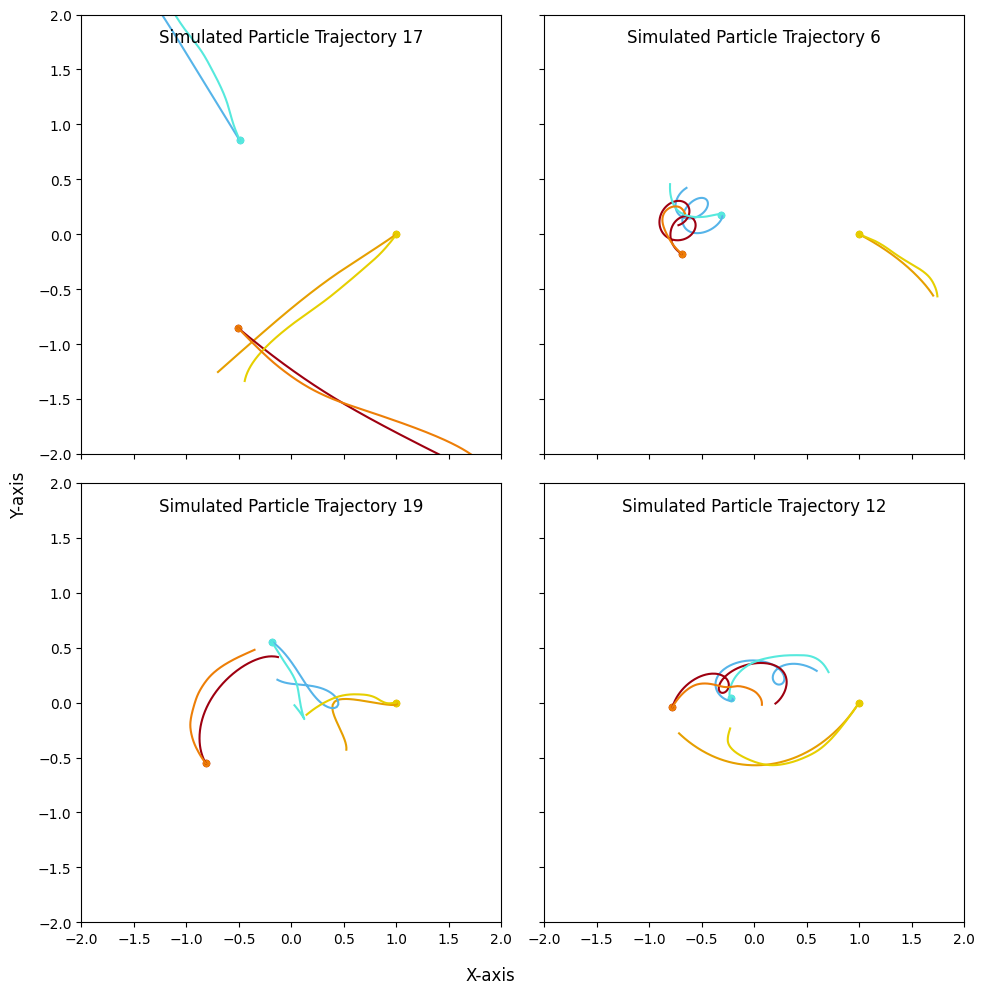

In [15]:
main()